This notebook shows various ways to introspect a `autoray.lazy` traced
computation, including scaling analysis. The basic steps for that are:

1. Choose prime numbers for all possible dimension sizes
2. Trace the computation with `lazy.array`
3. Call `compute_cost_scalings`

In [16]:
%config InlineBackend.figure_formats = ['retina']

import quimb as qu
import quimb.tensor as qtn

from autoray import lazy
from autoray.experimental.complexity_tracing import (
    cost_node,
    compute_cost,
    compute_cost_scalings,
    prime_factors,
    frequencies,
    closest_prime,
)

In [17]:
# all dimensions on intermediates must be different primes so that we can 
# decompose the costs for scaling analysis!
p = 2
D = 3
chi = 5

factor_map = {
    'p': p,
    'D': D,
    'chi': chi,
}

In [18]:
psi = qtn.PEPS.from_fill_fn(
    lambda shape: lazy.Variable(shape, backend='numpy'),
    # (could also call lazy.array on actual data)
    10, 10, D, phys_dim=p
)
norm = psi.make_norm()

In [19]:
Z = norm.contract_boundary(
    max_bond=chi,
    cutoff=0.0,
    sequence=['xmin'],
    layer_tags=('KET', 'BRA'),
    # layer_tags=None gives the single layer
)

# basic introspection

$W$ is the maximum tensor size or 'width':

In [20]:
W = Z.history_max_size()
W

13122

becase its a single tensor we can analyse its scaling:

In [21]:
prime_factors(W)

[2, 3, 3, 3, 3, 3, 3, 3, 3]

In [22]:
max_size_scaling = {
    name: frequencies(prime_factors(W)).get(size, 0)
    for name, size in factor_map.items()
}
max_size_scaling

{'p': 1, 'D': 8, 'chi': 0}

$M$ is 'peak size': maximum concurrent size of all intermediates.

In [23]:
# this is a sum so we can't decompose it
M = Z.history_peak_size()
M

27018

Which is the peak of this graph:

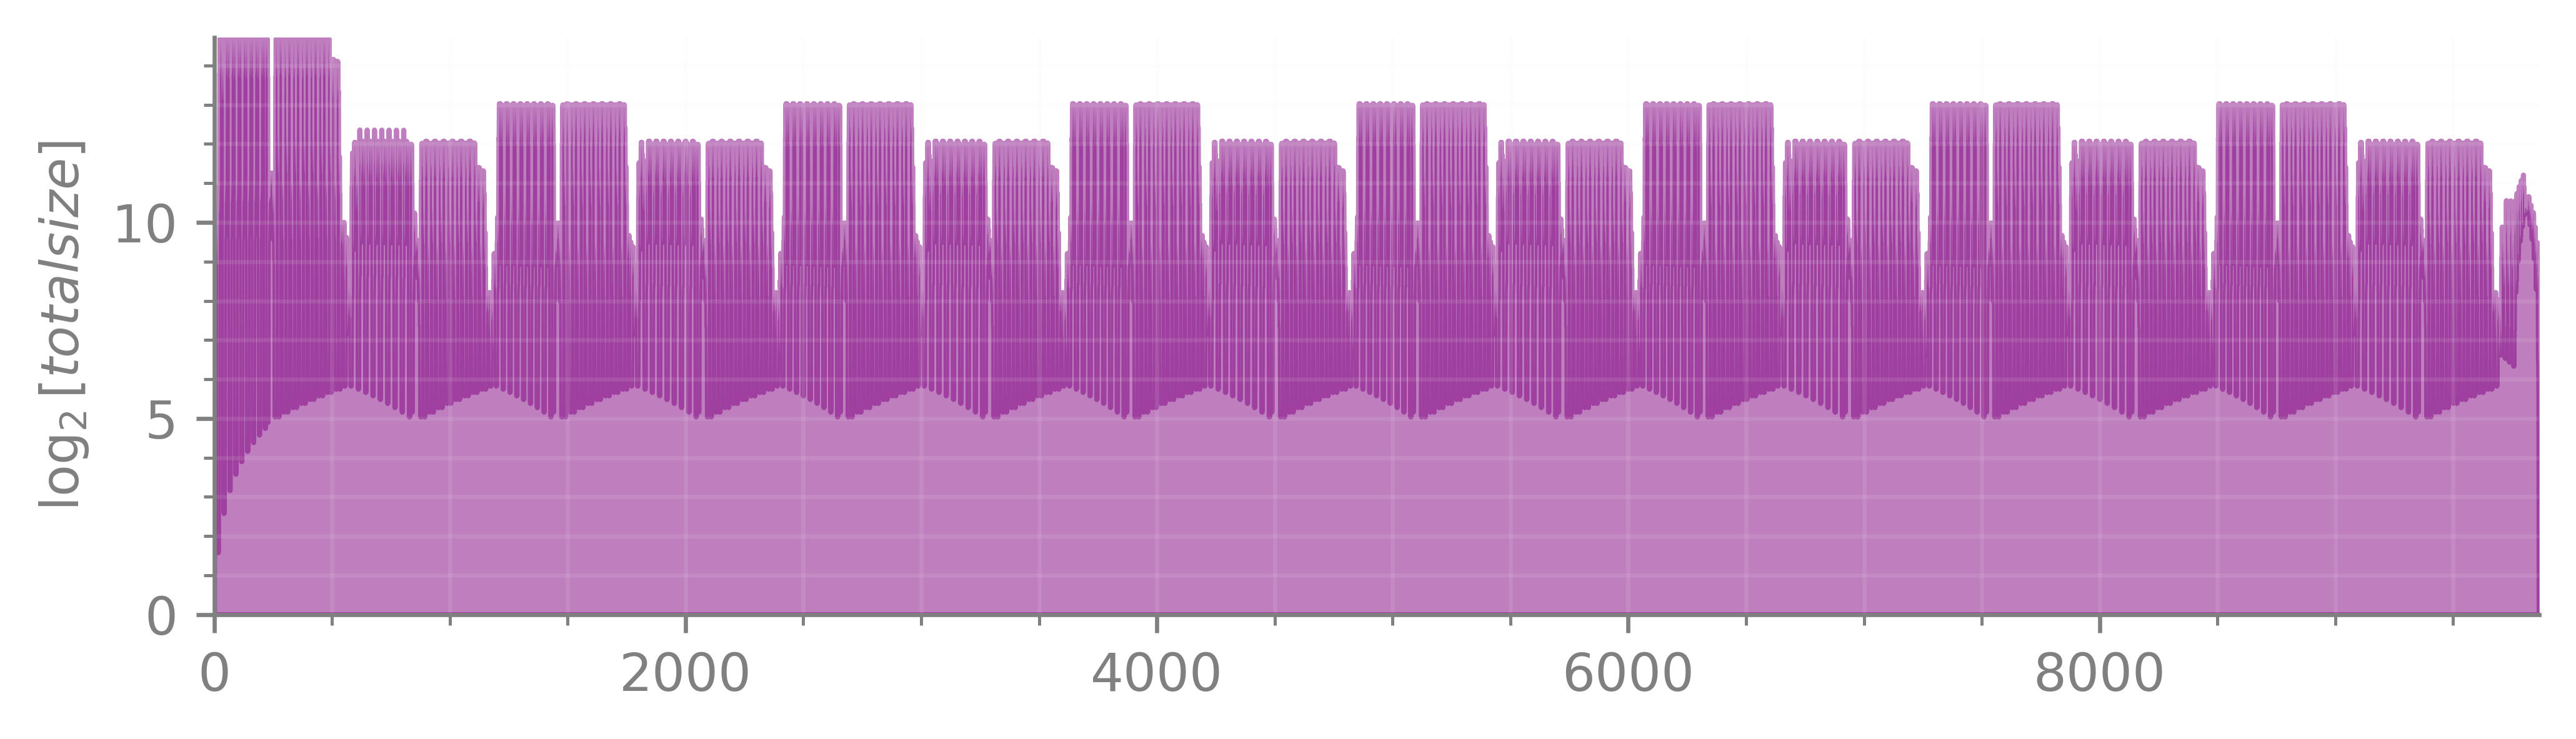

(<Figure size 2400x600 with 1 Axes>, <Axes: ylabel='$\\log_2[total size]$'>)

In [24]:
Z.plot_history_size_footprint(log=2)

$C$ is the estimated total flops:

In [25]:
# similarly for the total cost
C = compute_cost(Z)
C

56272536.0

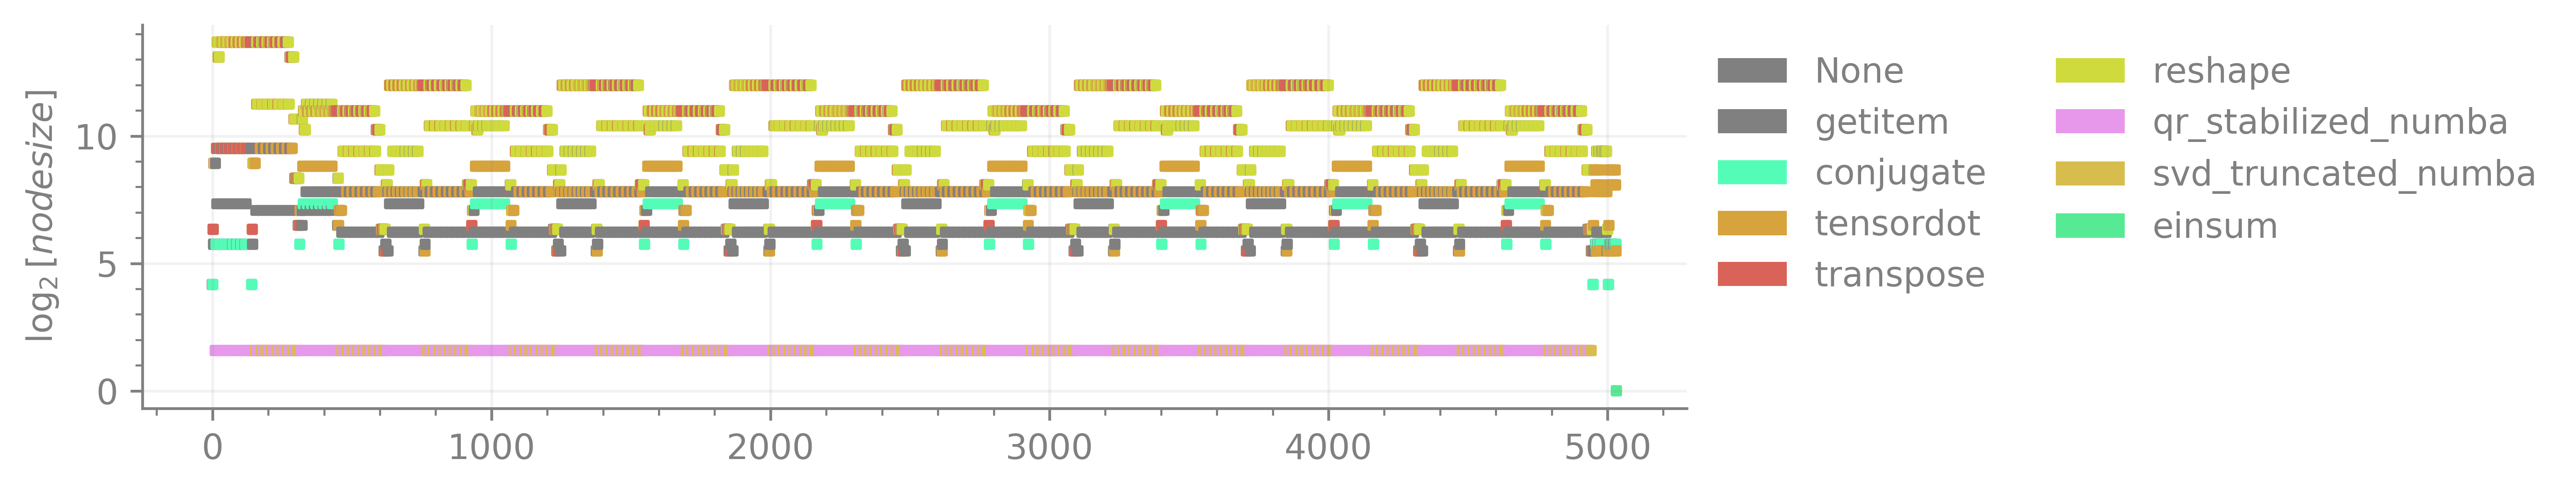

(<Figure size 2400x600 with 1 Axes>, <Axes: ylabel='$\\log_{2}[node size]$'>)

In [26]:
# history by size out
Z.plot_history_functions_scatter(log=2)

/mnt/ntfs/Sync/dev/python/autoray/autoray/lazy/draw.py:852: RuntimeWarning: divide by zero encountered in log2
  return np.log2(orig_fn(node)) / np.log2(log)


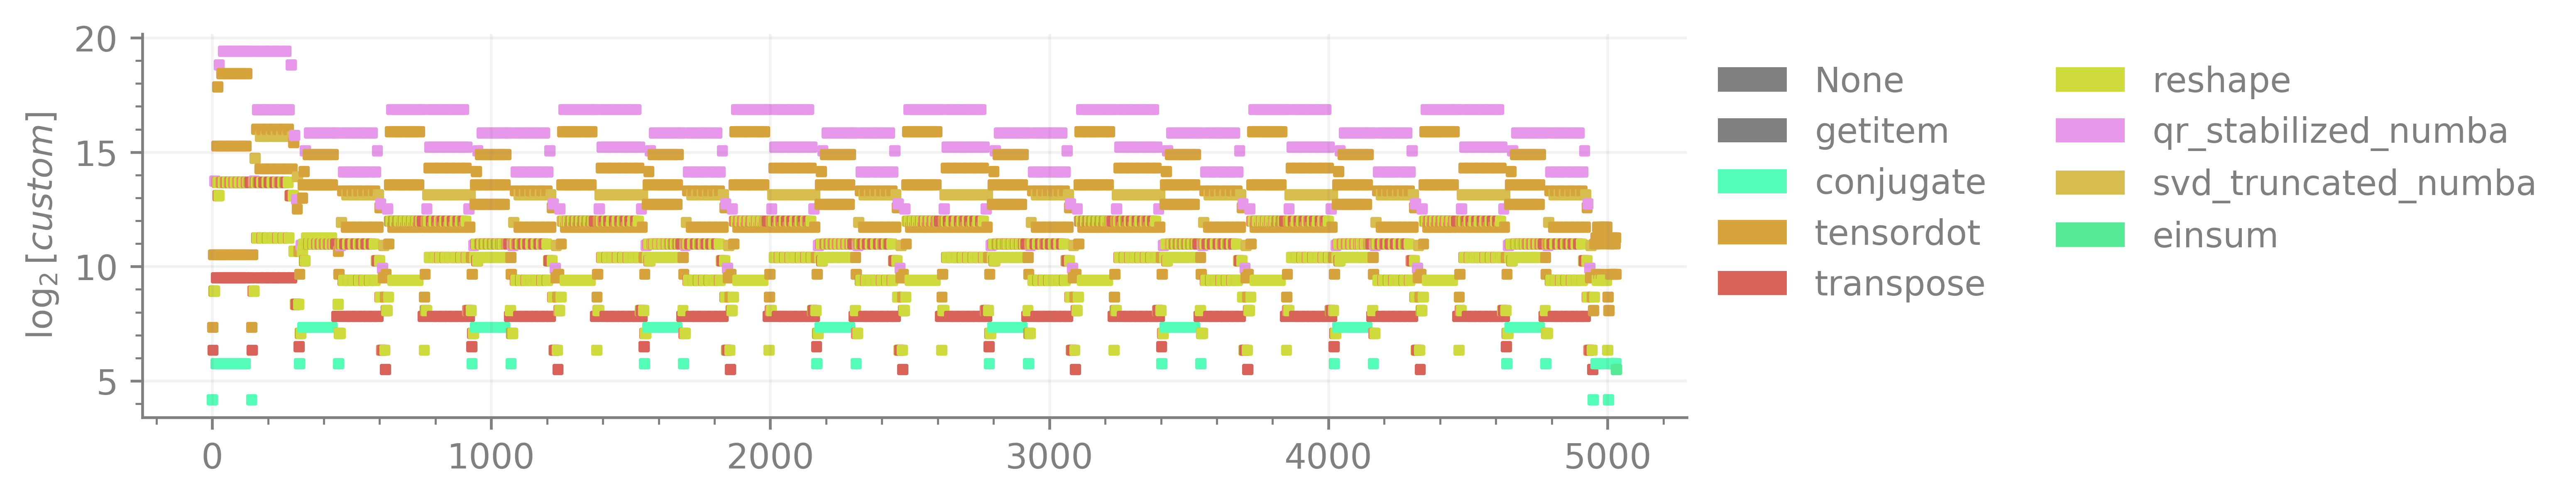

(<Figure size 2400x600 with 1 Axes>, <Axes: ylabel='$\\log_{2}[custom]$'>)

In [27]:
# history by cost
Z.plot_history_functions_scatter(log=2, fn=cost_node)

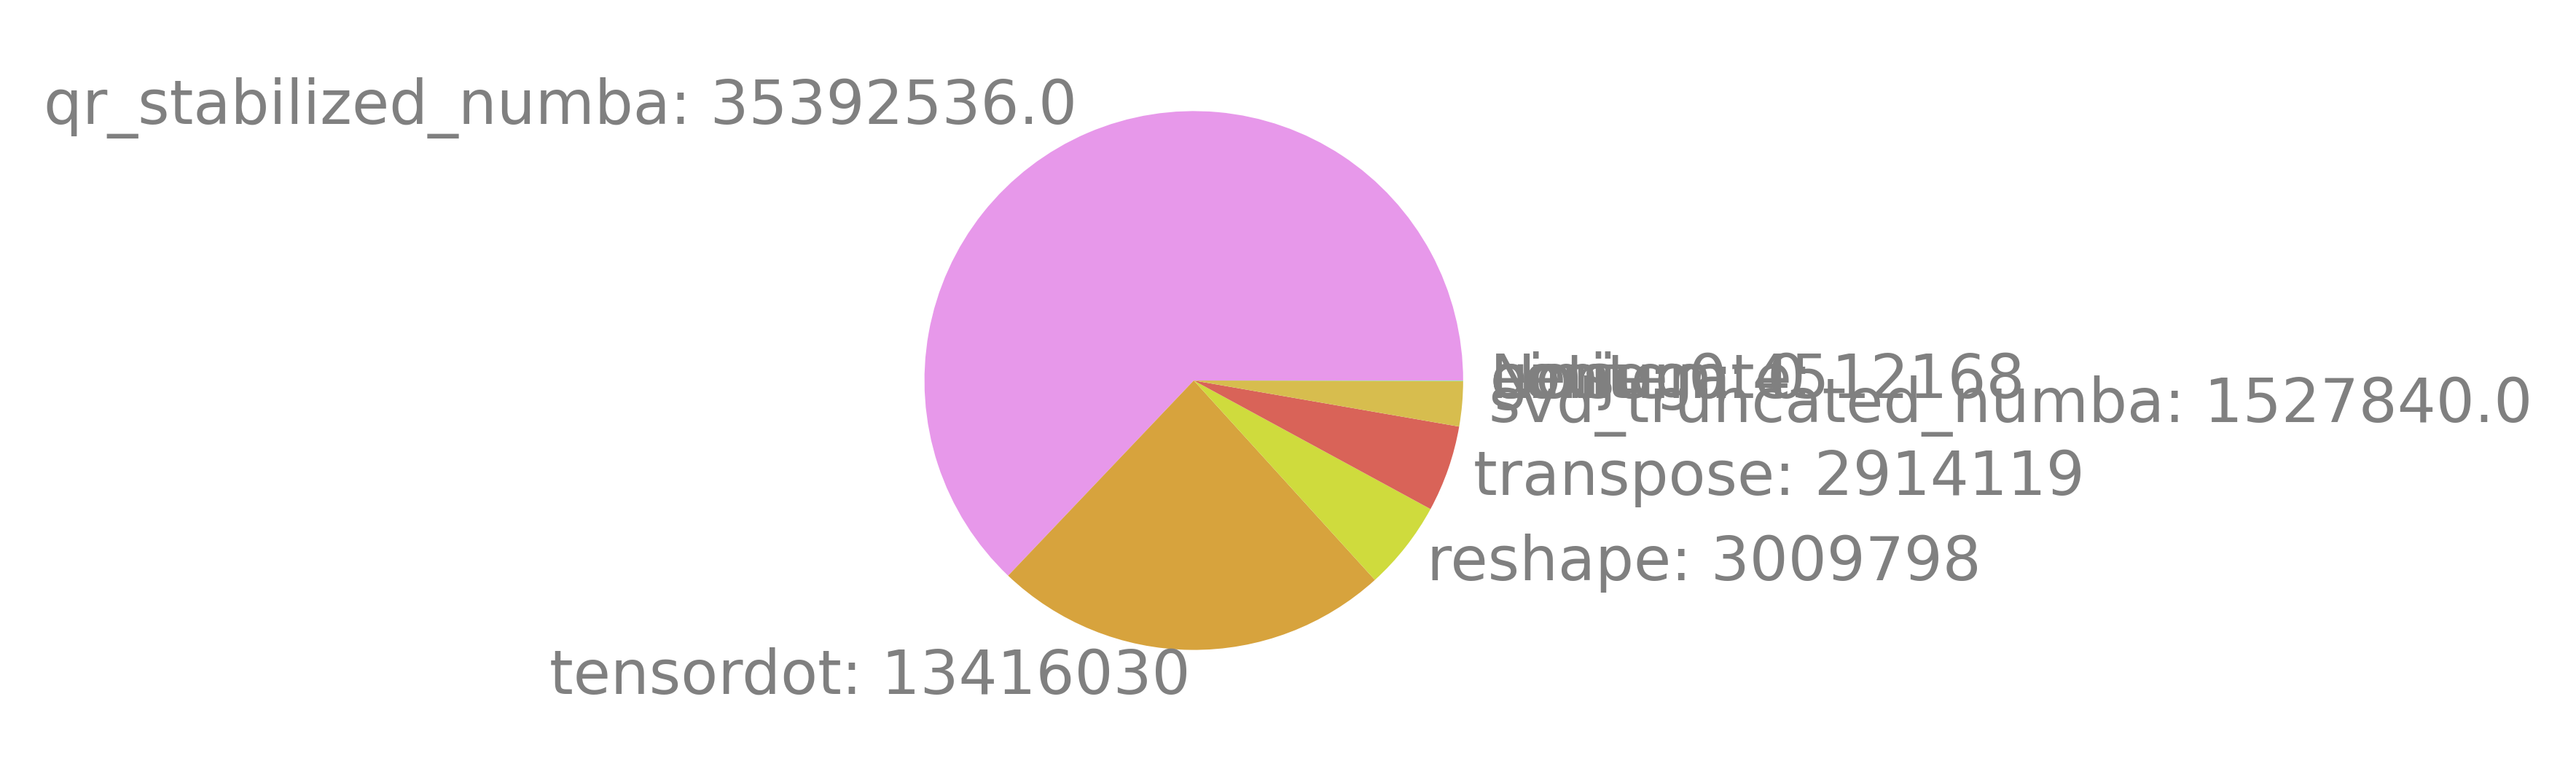

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [28]:
# combined cost into pie chart
Z.plot_history_stats(fn=cost_node)

# scaling of every computational node

For actual complexity we need decomposed scaling of every node:

In [29]:
scalings = compute_cost_scalings(Z, factor_map)

# these are sorted by cost
scalings[:10]

[{'cost': 354294,
  'name': 'qr_stabilized_numba',
  'freq': 14,
  'p': 1,
  'D': 11,
  'chi': 0},
 {'cost': 354294, 'name': 'tensordot', 'freq': 7, 'p': 1, 'D': 11, 'chi': 0},
 {'cost': 236196,
  'name': 'qr_stabilized_numba',
  'freq': 2,
  'p': 2,
  'D': 10,
  'chi': 0},
 {'cost': 236196, 'name': 'tensordot', 'freq': 1, 'p': 2, 'D': 10, 'chi': 0},
 {'cost': 65610,
  'name': 'qr_stabilized_numba',
  'freq': 7,
  'p': 1,
  'D': 8,
  'chi': 1},
 {'cost': 65610, 'name': 'tensordot', 'freq': 7, 'p': 1, 'D': 8, 'chi': 1},
 {'cost': 60750,
  'name': 'qr_stabilized_numba',
  'freq': 112,
  'p': 1,
  'D': 5,
  'chi': 3},
 {'cost': 60750, 'name': 'tensordot', 'freq': 56, 'p': 1, 'D': 5, 'chi': 3},
 {'cost': 43740, 'name': 'tensordot', 'freq': 1, 'p': 2, 'D': 7, 'chi': 1},
 {'cost': 39366, 'name': 'tensordot', 'freq': 8, 'p': 1, 'D': 9, 'chi': 0}]

If assume some relation like $\chi \sim D^p$ then you order all nodes. Or you
can plot the scaling of each like so:

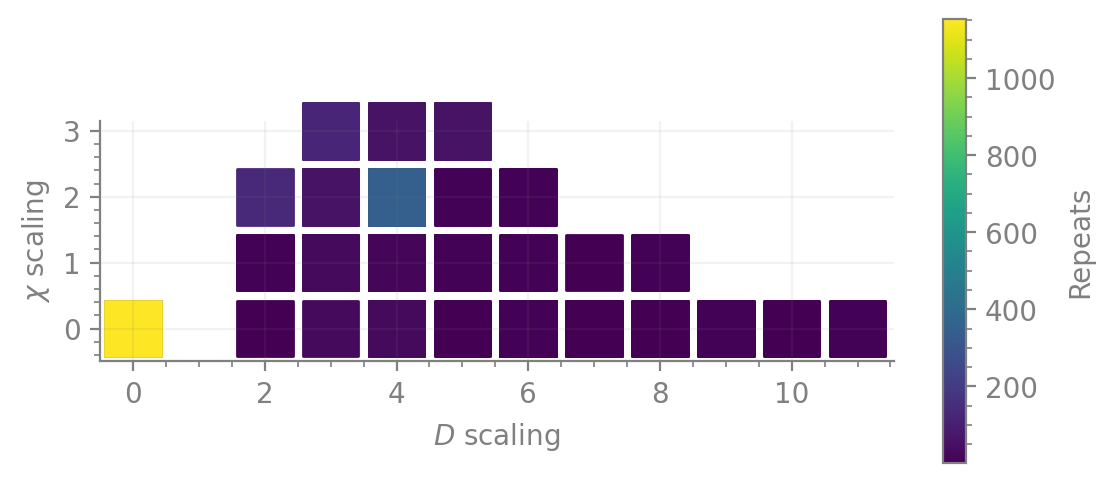

In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt

with mpl.style.context(qu.NEUTRAL_STYLE):
    plt.scatter(
        x=[s['D'] for s in scalings],
        y=[s['chi'] for s in scalings],
        c=[s['freq'] for s in scalings],
        s=400, marker='s', clip_on=False,
        alpha=1.0,
    )

    plt.xlabel('$D$ scaling')
    plt.ylabel('$\\chi$ scaling')

    plt.xlim(-0.5, None)
    plt.ylim(-0.5, None)
    plt.gca().set_aspect('equal')
    plt.colorbar(label='Repeats', shrink=0.6)
    plt.show()